# Rio Puerco historic data stage-to-discharge conversion procedure

This notebook reviews---and encodes!---the workflow for processing historical records of flow stage on the Rio Puerco, New Mexico.

(Written by Greg Tucker, July 2015. Modified Jan 2016)

## Step 1: prepare data in the work spreadsheet

The basic data consist of dates/times and gage-height measurements. There is one spreadsheet file per year, and within each file the data are grouped by day. The data were digitized from paper strip-chart records. Typically, only a few days of each year are represented: those that had significant flow.
A typical view of a spreadsheet looks like this:

<img src="spreadsheet_ex1.png">

Here the first day (4/29/41) has been processed already, as has part of the second.

### Step 1a: convert date/time to a serial number

We need to turn the date and time into a single number that represents the number of days elapsed since 1900. But first, we need to fill in the blue rows. These denote individual days in the record. We want each to contain the date/time value of midnight on the previous day (as in the example of 1941 04 30 0:00). Fill in these values in the blue columns MONTH, DAY, and TIME. Then use the Date() function in column E to turn these values into a single number. Add the time too. So, for example, in row 11, you'd insert: ``Date(A11, B11, C11) + D11''. Then drag this down through the full column for the file. Below we've done now done this for 5/1/41: <img src="spreadsheet_ex2.png">

### Step 1b: fill in missing stage values

Note that the blue columns, representing the very beginning/end of each day, are missing values. Interpolate between succeeding stage readings to fill these in. For cases, like this example, where the stage reading is the same before and after, it's easy: just enter the same value, as below: <img src="spreadsheet_ex3.png">

If the values are different, enter a formula in the "blue" cell to interpolate between them. The key is to have an accurate value for the beginning and end of each day, so we can calculate a meaningful (no pun) daily mean discharge.

### Step 1c: export the data for the day into a .csv file

Highlight columns E and F for the day in question (for example, 5/1/41). Copy these into a new spreadsheet. Save it as a .csv file, with a name like: rp_stage_time410501.csv. This file should then contain two columns of numbers separated by commas, as for example: <img src="csv_file_example.png">

Note how this record covers a full day, from midnight on 4/30/41 (=15097) to midnight on 5/1/41 (=15098).

## Step 2: using Python code to compute the stage-discharge relationship, and to find the stage shift that minimizes the difference between observed and computed daily mean discharge.

Start with some imports, and we'll define the step increment in stage that we'll use to iteratively adjust the rating table until we find a match between observed and calculated daily mean discharge.

In [42]:
import numpy
import pylab


dh = 0.005  # stage adjustment increment, feet

In a moment, we'll need a function to compute the daily mean discharge from a set of (time, discharge) pairs, so let's define it now.

In [3]:
def calc_mean_daily_discharge(t, q):
    """
    Uses the trapezoid method to compute mean discharge given a set of times
    and values.
    
    Parameters
    ----------
    t : array of float
        Times (in days) for discharge values
    q : array of float
        Discharge values (cfs)
        
    Example
    -------
    >>> import numpy
    >>> t = numpy.array([0., 2., 3., 8.])
    >>> q = numpy.array([2., 3., 5., 1.])
    >>> calc_mean_daily_discharge(t, q)
    3.0
    """
    n = len(t)
    assert(len(q)==n), 'unequal number of values for time and discharge'
    if n==1:  # if just one record, it IS the mean
        return q[0]
    dt = t[1:]-t[:n-1]          # time increment between readings
    qpair = (q[:n-1]+q[1:])/2   # average discharge between pairs
    total_time = t[-1] - t[0]   # elapsed time from beginning to end of record
    assert (total_time>0.0), 'hydrograph must have duration >0'
    return numpy.sum(dt*qpair)/total_time  # return the weighted average
    

Enter the name of the rating table to be used. This can be found in column I of the spreadsheet. Find the corresponding file, and enter its name as ``rating_table_filename``:

In [4]:
rating_table_filename = 'rating_table_19381001to19450930.csv'

Enter the name of the .csv file you created in step 1c above as ``hydrograph_filename``:

In [11]:
hydrograph_filename = 'rp_stage_time410501.csv'   # stage vs time, in ft and decimal days

Now, enter the reported daily mean discharge in cfs, as ``qm``. For the "Rio Puerco at Rio Puerco" gage, the value can be found in the spreadsheet file "RPatRP_DailyMeanDischarge.xlsx". For the Bernardo gage, the value can be found in "RPnrBer_DailyMeanDischarge.xlsx".

In [31]:
qm = 414.0  # mean daily Q for this day, in cfs

Read in the rating table:

In [32]:
rt = numpy.loadtxt(rating_table_filename, delimiter=',')
rt_gage_height = numpy.array(rt[:,0])
rt_discharge = numpy.array(rt[:,1])

Plot it to make sure it's ok.

Populating the interactive namespace from numpy and matplotlib


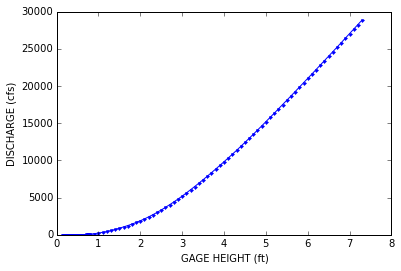

In [33]:
%pylab inline
pylab.figure(1)
pylab.plot(rt_gage_height, rt_discharge, '.-')
pylab.xlabel('GAGE HEIGHT (ft)')
pylab.ylabel('DISCHARGE (cfs)')

Read in the time-stage data:

In [34]:
hydro_data = numpy.loadtxt(hydrograph_filename, delimiter=',')
decimal_day = hydro_data[:,0]
gage_height = hydro_data[:,1]

Let's plot this information too, to make sure all is well.

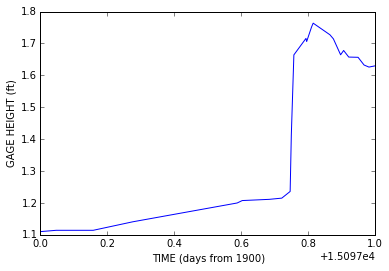

In [35]:
pylab.plot(decimal_day, gage_height)
pylab.xlabel('TIME (days from 1900)')
pylab.ylabel('GAGE HEIGHT (ft)')

Find discharge corresponding to stage records via linear interpolation, the corresponding daily mean discharge, and the percent error:

In [57]:
q = numpy.interp(gage_height, rt_gage_height, rt_discharge)
qm_pred0 = calc_mean_daily_discharge(decimal_day, q)
q_err0 = (qm-qm_pred0)/qm

In [58]:
qm, qm_pred0, q_err0

(414.0, 607.16402723483407, -0.46657977592955091)

If the % error is less than 5%, we're good to go. More likely, however, it will be way off, so we will iterate on adjusting the stage shift until we find a better match. This is a simple stepping algorith in which we increase or decrease the stage measurements until the sign of the error reverses, meaning we've crossed a minimum point.

In [62]:
niter = 0
h_adj = 0.0
prev_q_err = q_err0
best_adj = 0.0
best_qm = qm_pred0
best_abs_q_err = abs(q_err0)
dir_adj = numpy.sign(q_err0)
q_err = q_err0
while abs(q_err)<=abs(prev_q_err) and niter<100:
    h_adj += dir_adj*dh
    q = numpy.interp(gage_height+h_adj, rt_gage_height, rt_discharge)
    qm_pred = calc_mean_daily_discharge(decimal_day, q)
    prev_q_err = q_err
    q_err = (qm-qm_pred)/qm
    print 'adjustment =',h_adj,'  qm_pred =',qm_pred,'  q_err =',q_err
    if abs(q_err)<best_abs_q_err:
        best_qm = qm_pred
        best_abs_q_err = abs(q_err)
        best_adj = h_adj
    niter += 1

adjustment = -0.005   qm_pred = 600.225312235   q_err = -0.44981959477
adjustment = -0.01   qm_pred = 593.305579903   q_err = -0.433105265467
adjustment = -0.015   qm_pred = 586.482252431   q_err = -0.416623798142
adjustment = -0.02   qm_pred = 579.871942798   q_err = -0.400656866662
adjustment = -0.025   qm_pred = 573.265170298   q_err = -0.384698478981
adjustment = -0.03   qm_pred = 566.676703489   q_err = -0.368784307943
adjustment = -0.035   qm_pred = 560.109059315   q_err = -0.352920433128
adjustment = -0.04   qm_pred = 553.551122888   q_err = -0.337080006975
adjustment = -0.045   qm_pred = 547.176707922   q_err = -0.321682869377
adjustment = -0.05   qm_pred = 540.835040422   q_err = -0.306364831937
adjustment = -0.055   qm_pred = 534.516864148   q_err = -0.291103536588
adjustment = -0.06   qm_pred = 528.223151171   q_err = -0.275901331332
adjustment = -0.065   qm_pred = 521.943487922   q_err = -0.260733062613
adjustment = -0.07   qm_pred = 515.688105422   q_err = -0.245623443048


Here's the best-fit stage adjustment (in feet), and the corresponding % error:

In [63]:
best_qm, best_adj, 100*best_abs_q_err

(414.73427036544274, -0.15500000000000005, 0.17735999165283564)

Since we probably overshot the best-fit, go back and interpolate again with our best-fit adjustment.

In [66]:
q = numpy.interp(gage_height+best_adj, rt_gage_height, rt_discharge)

Plot the resulting hydrograph (alongside the daily mean) to make sure it looks reasonable.

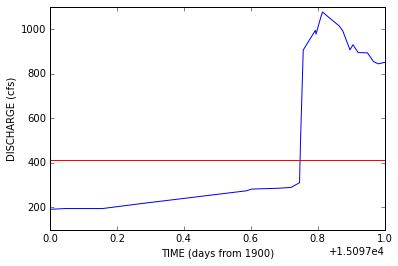

In [67]:
pylab.plot(decimal_day, q)
pylab.plot([decimal_day[0], decimal_day[-1]], [qm, qm], 'r')
pylab.xlabel('TIME (days from 1900)')
pylab.ylabel('DISCHARGE (cfs)')

Write the results to a pair of files.

In [68]:
output_filename = 'discharge-'+hydrograph_filename
numpy.savetxt(output_filename, q)
output_filename = 'adjusted_stage-'+hydrograph_filename
numpy.savetxt(output_filename, gage_height+best_adj)
q

array([  191.75      ,   195.2450759 ,   195.2450759 ,   217.89754445,
         274.77245   ,   282.386725  ,   286.193863  ,   290.001001  ,
         310.940258  ,   525.3638028 ,   905.7135063 ,   993.5727244 ,
         976.9069784 ,  1054.2489799 ,  1075.7541364 ,  1054.2489799 ,
        1012.9891248 ,   991.1456735 ,   906.1989158 ,   929.2558934 ,
         894.0636647 ,   892.8501401 ,   853.84968   ,   843.5704096 ,
         850.        ])

## Step 3: bring the data back to the spreadsheet

In the column labeled BEST-FIT ADDITIONAL SHIFT (note: you might need to create this column), enter the best-fitting shift value calculated above (place it in each row). If column "FINAL ADJUSTED GAGE HEIGHT" (which you might also need to create) is not already filled in, enter the formula to calculate sum of ADJUSTED GAGE HEIGHT and BEST-FIT SHIFT. For example, the 5/1/41 record, with a best-fit shift of -0.155 ft, should look like: <img src="adjusted_gage_height410501.png">

Open the discharge text files, and paste its contents into the appropriate locations in the column labeled CALCULATED DISCHARGE. Also enter calculated daily mean, and configure the % ERROR column to calculate the percent error between reported and calculated. For example, for 5/1/41: <img src="discharge_entries.png">

That's all folks!